## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import datetime
import pytorch_lightning as pl
from collections import namedtuple
sys.path.insert(0, '../')
from config.base_config import parse_args
import deca_dpm
from guided_diffusion.script_util import (
    create_deca_and_diffusion,
    seed_all,
)
cfg_file = "../config/Condition_Deca/cond_deca_by_img64_attention.yaml"
# cfg_file = "../config/Uncondition_Deca/magenta_deca.yaml"
cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})

Merging with :  Namespace(cfg='../config/Condition_Deca/cond_deca_by_img64_attention.yaml')



In [2]:
# List model_logs

ct = ""
sshfs_path = "/data/mint/model_logs/"
# ct = "v6"
# sshfs_path = "/data/mint/model_logs_mount/"
model_logs_path = f"{sshfs_path}/{ct}/"

log_dir = "cond_deca_by_img64_pool_attention"
# log_dir = "magenta"

# step = "275000"
step = "100000"
set_ = "valid"
name = cfg.param_model.name
# ckpt = f"model{step}"
ckpt = f"ema_0.9999_{step}"
deca_model_path = f"{model_logs_path}/{log_dir}/{name}_{ckpt}.pt"

deca_model, diffusion = create_deca_and_diffusion(cfg)

deca_model.load_state_dict(
    th.load(deca_model_path, map_location="cpu")
)

deca_model.to('cuda')
deca_model.eval()


DenseDDPMCond(
  (in_layers): Linear(in_features=159, out_features=2048, bias=True)
  (mid_layers): ModuleList(
    (0): Sequential(
      (0): DenseFiLM(
        (time_embed): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
        (scale_layer): Linear(in_features=512, out_features=2048, bias=True)
        (shift_layer): Linear(in_features=512, out_features=2048, bias=True)
      )
      (1): DenseResBlock(
        (resblock): Sequential(
          (0): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (1): FeaturewiseAffine()
          (2): SiLU()
          (3): Linear(in_features=2048, out_features=2048, bias=True)
          (4): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (5): FeaturewiseAffine()
          (6): SiLU()
          (7): Linear(in_features=2048, out_features=2048, bias=True)
        )
      )
    )
    (

In [3]:
from guided_diffusion.dataloader.img_util import decolor

def plot_sample(img, **kwargs):
    columns = 6
    rows = 10
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()

def plot_deca(sample):

    img_ = []
    from tqdm.auto import tqdm
    for i in tqdm(range(sample['deca_output'].shape[0])):
        deca_params = sample['deca_output'][i].clone()
        deca_params = denormalize(deca_params, min_val=th.tensor(min_value_train).cuda(), max_val=th.tensor(max_value_train).cuda(), a=-cfg.param_model.bound, b=cfg.param_model.bound).float()
        shape = deca_params[None, :100]
        pose = deca_params[None, 100:106]
        exp = deca_params[None, 106:156]
        cam = deca_params[None, 156:]
        img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
        img_.append(img["shape_images"])

    plot_sample(th.cat(img_, dim=0))
    return th.cat(img_, dim=0)
        

In [4]:
from ast import Expression, arg, parse
from pickle import PickleError
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn.functional as F
import glob, os
import PIL
import matplotlib.pyplot as plt
from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from collections import defaultdict
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
import model_3d.FLAME.utils.detectors as detectors
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale

flame = FLAME.FLAME(flame_cfg.model).cuda()

def params_to_model(shape, exp, pose, cam, i, uvdn=None):
    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)
    renderer = SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    opdict = {'verts' : verts,}

    os.makedirs('./rendered_obj', exist_ok=True)
    save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    
    return {"shape_images":shape_images, "landmarks2d":landmarks2d, "landmarks3d":landmarks3d}

def save_obj(renderer, filename, opdict):
    '''
    vertices: [nv, 3], tensor
    texture: [3, h, w], tensor
    '''
    i = 0
    vertices = opdict['verts'][i].cpu().numpy()
    faces = renderer.faces[0].cpu().numpy()
    colors = np.ones(shape=vertices.shape) * 127.5

    # save coarse mesh
    util.write_obj(filename, vertices, faces, colors=colors)

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def normalize(arr, min_val=None, max_val=None, a=-1, b=1):
    '''
    Normalize any vars to [a, b]
    :param a: new minimum value
    :param b: new maximum value
    :param arr: np.array shape=(N, #params_dim) e.g. deca's params_dim = 159
    ref : https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    '''
    if max_val is None and min_val is None:
        max_val = np.max(arr, axis=0)    
        min_val = np.min(arr, axis=0)

    arr_norm = ((b-a) * (arr - min_val) / (max_val - min_val)) + a
    return arr_norm, min_val, max_val

def denormalize(arr_norm, min_val, max_val, a=-1, b=1):
    arr_denorm = (((arr_norm - a) * (max_val - min_val)) / (b - a)) + min_val
    return arr_denorm

def load_params(path, params_key):

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params)

    return params_s, all_params

# Load params
params_key = ['shape', 'pose', 'exp', 'cam']
params_train, params_train_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
_, min_value_train, max_value_train = normalize(a=-cfg.param_model.bound, b=cfg.param_model.bound, arr=params_train_arr)

params_valid, params_valid_arr = load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)
_, min_value_valid, max_value_valid = normalize(a=-cfg.param_model.bound, b=cfg.param_model.bound, arr=params_valid_arr)


creating the FLAME Decoder
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-cam-anno.txt
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt


In [5]:
# Load image for condition (if needed)
import blobfile as bf
import random
from guided_diffusion.dataloader.img_util import (
    random_crop_arr,
    center_crop_arr,
    resize_arr
)

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def augmentation(pil_image):
        # Resize image by resizing/cropping to match the resolution
        if cfg.img_model.resize_mode == 'random_crop':
            arr = random_crop_arr(pil_image, cfg.img_model.image_size)
        elif cfg.img_model.resize_mode == 'center_crop':
            arr = center_crop_arr(pil_image, cfg.img_model.image_size)
        elif cfg.img_model.resize_mode == 'resize':
            arr = resize_arr(pil_image, cfg.img_model.image_size)
        else: raise NotImplemented

        return arr

path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}"
all_files = _list_image_files_recursively(path)

def load_condition(n=10, vis=False):
    imgs = []
    for path in all_files[:n]:
        with bf.BlobFile(path, "rb") as f:
            pil_image = PIL.Image.open(f)
            pil_image.load()
            pil_image = pil_image.convert("RGB")

            raw_img = augmentation(pil_image=pil_image)

            raw_img = (raw_img / 127.5) - 1

        imgs.append(np.transpose(raw_img, (2, 0, 1)))
    imgs = np.stack(imgs)
    if vis:
        plot_sample(th.tensor(imgs))
    return {'image':th.tensor(imgs).cuda()}


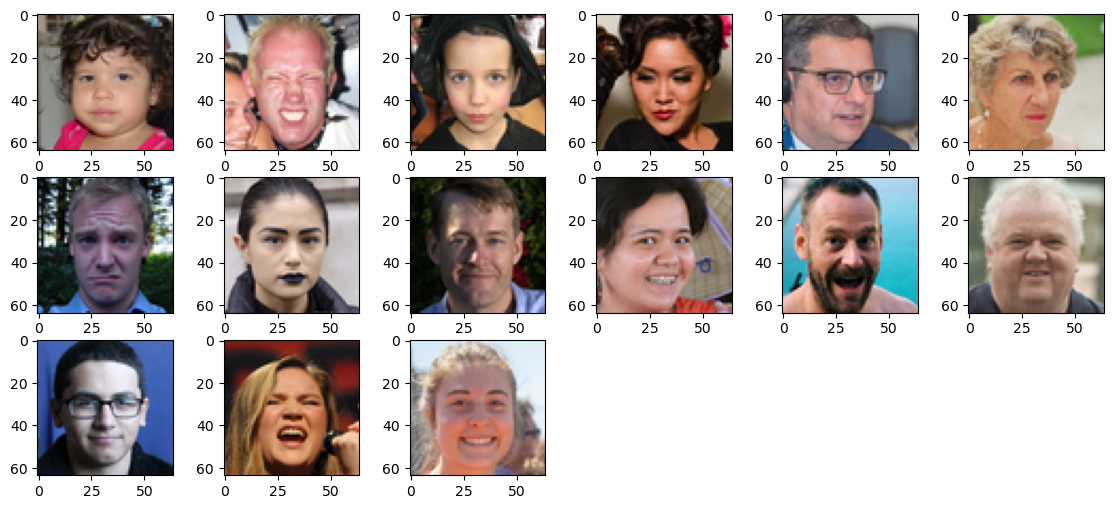

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

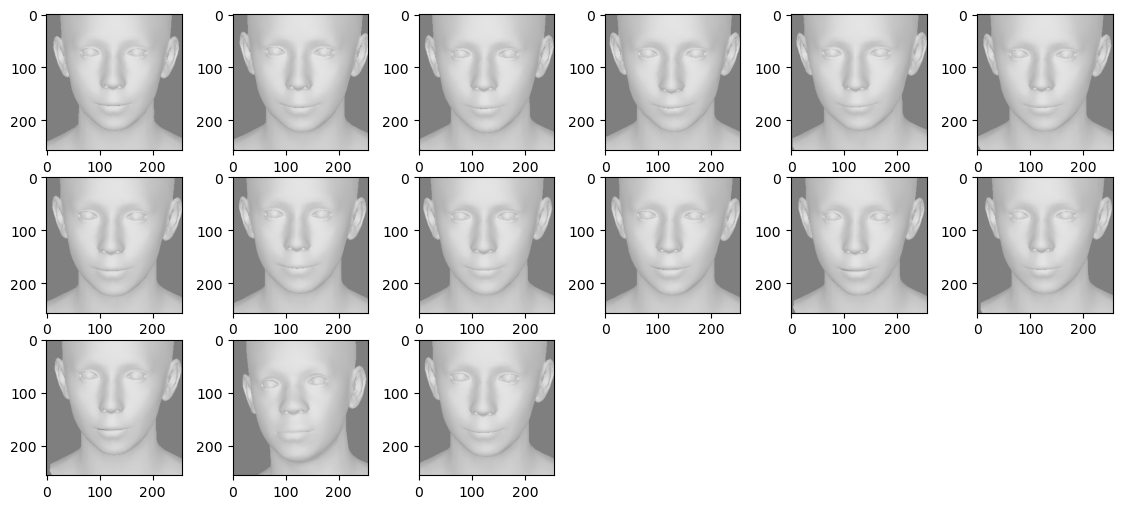

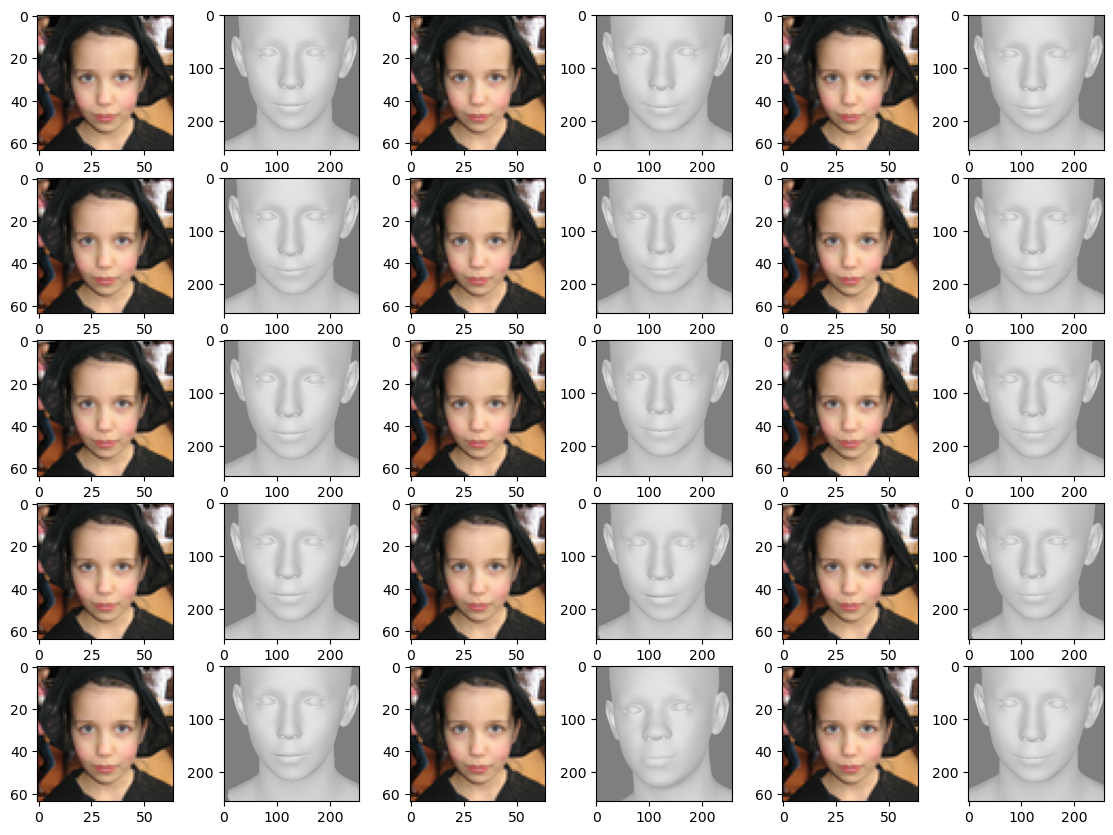

In [10]:
batch_size = 15
model_kwargs = {}
model_kwargs.update(load_condition(n=batch_size, vis=True))
# model_kwargs['image'] = th.stack([model_kwargs['image'][2]]*batch_size, dim=0)
class PLInference(pl.LightningModule):
    def __init__(self, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.deca_model = deca_model
        self.sample_fn = sample_fn

    def forward(self, noise=None):
        # seed_all(33)
        sample = self.sample_fn(
            model=self.deca_model,
            shape=(noise.shape[0], 159) if noise is not None else (batch_size, 159),
            noise=noise,
            clip_denoised=cfg.diffusion.clip_denoised,
            model_kwargs=model_kwargs
        )
        return {"deca_output":sample}

# Normal Sampling 
init_noise = th.randn((batch_size, 159)).cuda()
# init_noise = th.cat(([th.randn((1, 159)).cuda()] * args.batch_size), dim=0)
pl_inference = PLInference(deca_model=deca_model, sample_fn=diffusion.ddim_sample_loop)#p_sample_loop)
sample_ddim = pl_inference(noise=init_noise)
sample_deca = plot_deca(sample_ddim)
plot_sample(img=model_kwargs['image'], render_img=sample_deca)


# Analysis of Face params

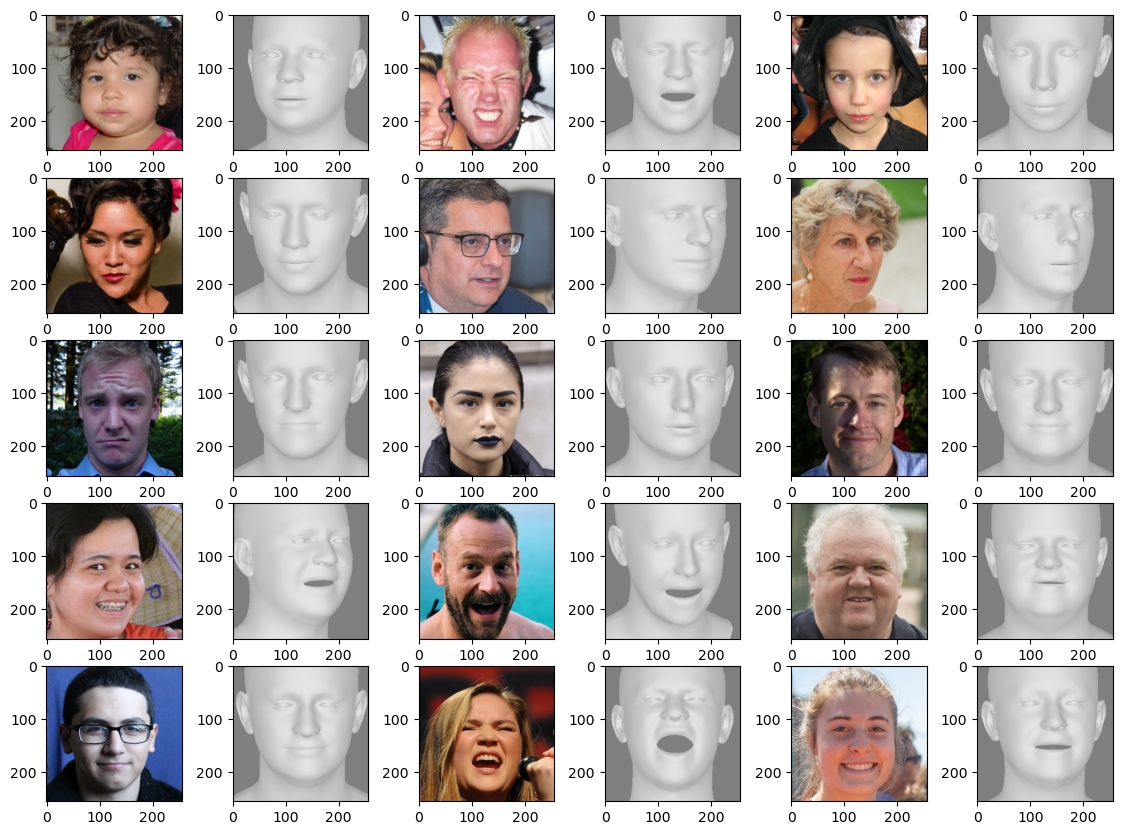

In [7]:
img_dataset_path = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/'
if cfg.param_model.conditioning:
    img_name_list = [img_name.split('/')[-1] for img_name in all_files[:batch_size]]
else:
    img_name_list = [str(n) + '.jpg' for n in list(np.random.randint(0, 60000, 10))]

if set_ == 'valid':
    params = params_valid
elif set_ == 'train':
    params = params_train
else: raise NotImplementedError

render_img_list = []
src_img_list = []
img_list = []
for img_name in img_name_list:
    shape = th.tensor(params[img_name]['shape'][None, :]).float().cuda()
    pose = th.tensor(params[img_name]['pose'][None, :]).float().cuda()
    exp = th.tensor(params[img_name]['exp'][None, :]).float().cuda()
    cam = th.tensor(params[img_name]['cam'][None, :]).float().cuda()

    src_img = PIL.Image.open(img_dataset_path + img_name)
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

    render_img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=img_name)
    render_img_list.append(render_img["shape_images"])

src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
plot_sample(img=src_img, render_img=render_img)